# Veri Setinin Hikayesi 

In [ ]:
######################################################
# Diabetes Prediction with Logistic Regression
######################################################

# İş Problemi:

# Özellikleri belirtildiğinde kişilerin diyabet hastası olup
# olmadıklarını tahmin edebilecek bir makine öğrenmesi
# modeli geliştirebilir misiniz?

# Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin
# parçasıdır. ABD'deki Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan
# Pima Indian kadınları üzerinde yapılan diyabet araştırması için kullanılan verilerdir. 768 gözlem ve 8 sayısal
# bağımsız değişkenden oluşmaktadır. Hedef değişken "outcome" olarak belirtilmiş olup; 1 diyabet test sonucunun
# pozitif oluşunu, 0 ise negatif oluşunu belirtmektedir.

# Değişkenler
# Pregnancies: Hamilelik sayısı
# Glucose: Glikoz.
# BloodPressure: Kan basıncı.
# SkinThickness: Cilt Kalınlığı
# Insulin: İnsülin.
# BMI: Beden kitle indeksi.
# DiabetesPedigreeFunction: Soyumuzdaki kişilere göre diyabet olma ihtimalimizi hesaplayan bir fonksiyon.
# Age: Yaş (yıl)
# Outcome: Kişinin diyabet olup olmadığı bilgisi. Hastalığa sahip (1) ya da değil (0)


# 1. Exploratory Data Analysis
# 2. Data Preprocessing
# 3. Model & Prediction
# 4. Model Evaluation
# 5. Model Validation: Holdout
# 6. Model Validation: 10-Fold Cross Validation
# 7. Prediction for A New Observation

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_validate

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)


In [5]:
df = pd.read_csv("diabetes.csv")

##########################
# Target'ın Analizi
##########################

df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

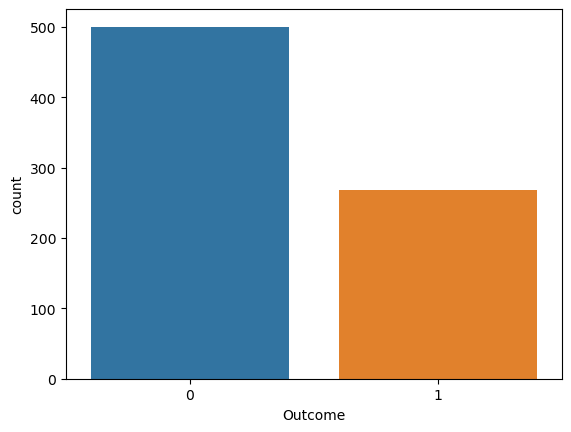

In [7]:
sns.countplot(x="Outcome", data=df)
plt.show()

In [9]:
100 * df['Outcome'].value_counts() / len(df)
# satır sayıları olan 768i 500e ve 268 e bölerek

0   65.104
1   34.896
Name: Outcome, dtype: float64

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


<AxesSubplot:>

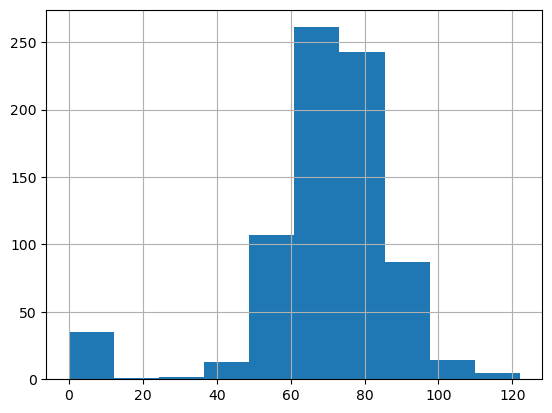

In [16]:
df['BloodPressure'].hist()

<AxesSubplot:>

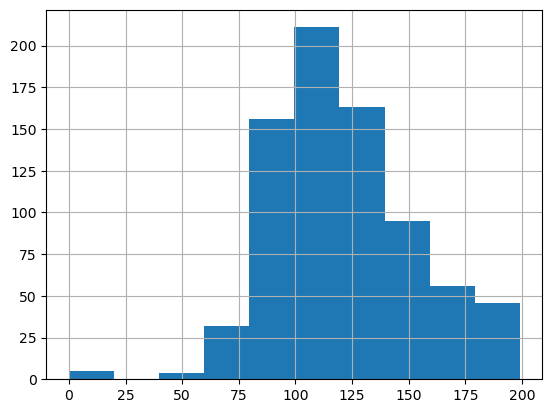

In [21]:
df['Glucose'].hist()

In [23]:
def plot_numerical_col(dataframe, numerical_col):
    dataframe[numerical_col].hist(bins=20)
    plt.xlabel(numerical_col)
    plt.show(block=True)

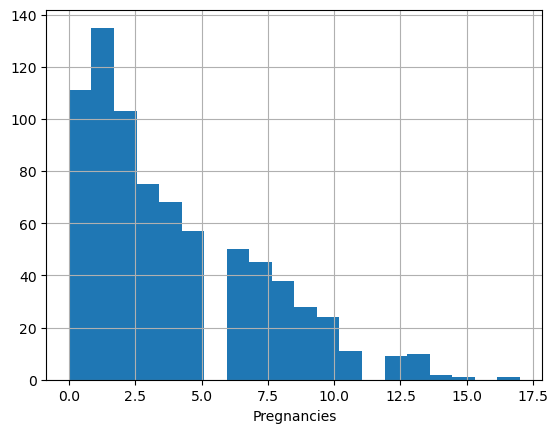

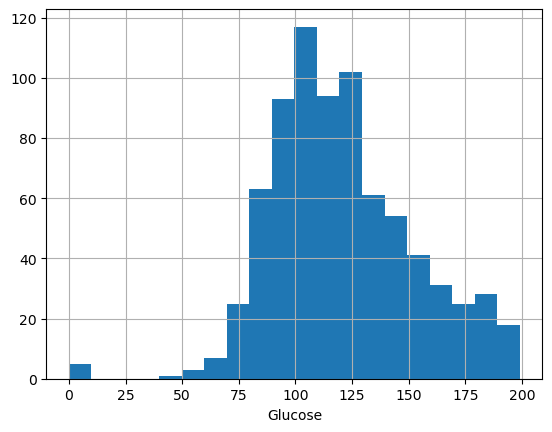

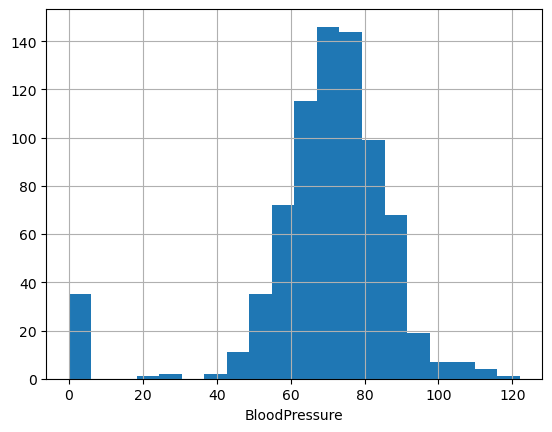

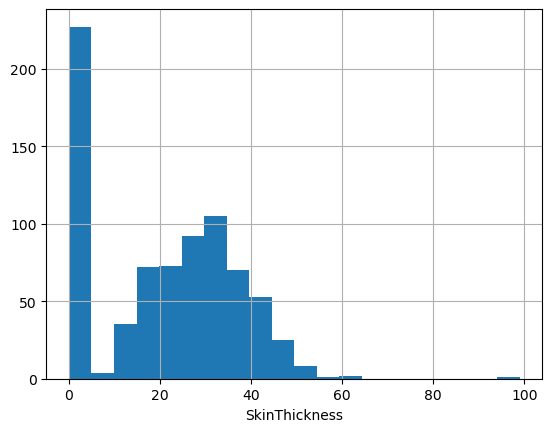

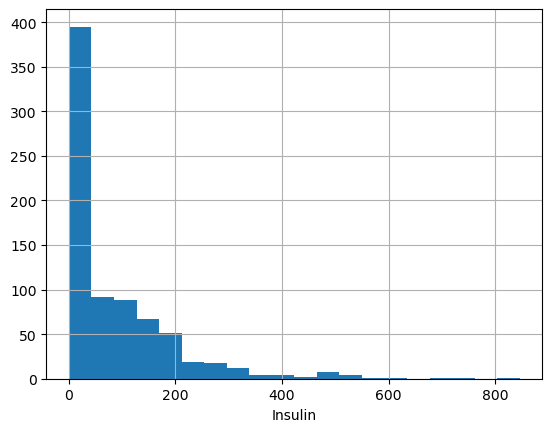

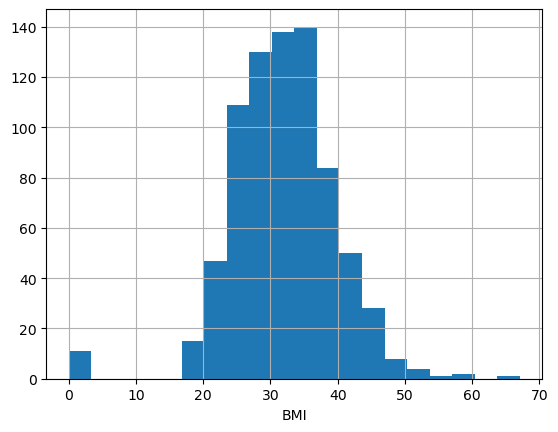

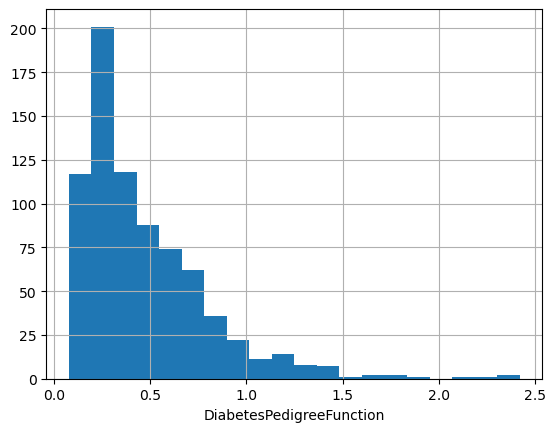

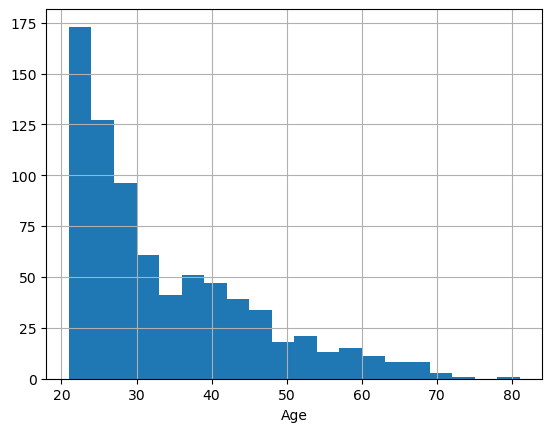

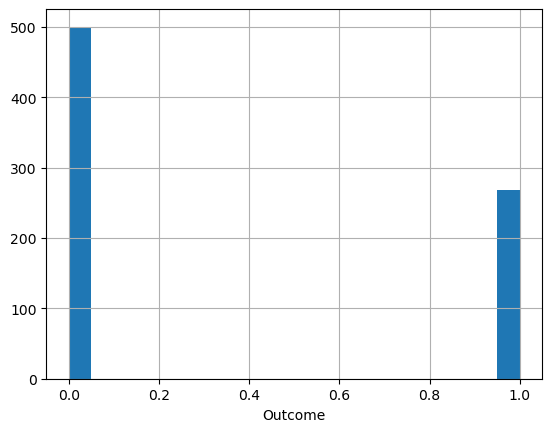

In [26]:
for col in df.columns:
    plot_numerical_col(df,col)

In [27]:
df.groupby('Outcome').agg({"Pregnancies":"mean"})

,Pregnancies
Outcome,
0,3.298
1,4.866


In [29]:
##########################
# Target vs Features
##########################
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [31]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [32]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [39]:
for col in df.columns:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [40]:
replace_with_thresholds(df, 'Insulin')

In [46]:
# Veriyi standartlaştırmamız lazım
# Çünkü modlein değişkenklere eşit yaklaşmasını sağlamamız gerekir
# değerleri daha büyük olanın küçük olana üstünlüğü olmamamsı gerekir 
# kullanılan parametre tahmin yöntemlerinin daha hızlı ve  daha doğru tahminlerde bulunması için kullanırız 
# RobustScaler fonksiyonu bütün gözlem birimlerinin değerlerinden medyanı çıkarıp
# range değerine bölüyor
# aykırı değerlere dayanıklı olduğu için bunu tercih ettik 
for col in df.columns:
    df[col] = RobustScaler().fit_transform(df[[col]])

In [47]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.600,0.752,0.000,0.375,-0.240,0.172,0.665,1.235,1.000
1,-0.400,-0.776,-0.333,0.188,-0.240,-0.581,-0.056,0.118,0.000
2,1.000,1.600,-0.444,-0.719,-0.240,-0.935,0.783,0.176,1.000
3,-0.400,-0.679,-0.333,0.000,0.499,-0.419,-0.537,-0.471,0.000
4,-0.600,0.485,-1.778,0.375,1.081,1.194,5.008,0.235,1.000


In [ ]:
# 'Modelleme' (Amacımız bağımlı ve bağımısz değişkenler arasındaki ilişkiyi modellemek)

In [49]:
y = df['Outcome']

X = df.drop(['Outcome'], axis=1)

log_model = LogisticRegression().fit(X, y)

LogisticRegression()

In [54]:
log_model.coef_

array([[ 0.59906785,  1.41770936, -0.23152362,  0.01973855, -0.14571255,
         0.81741997,  0.35522795,  0.25655154]])

In [60]:
y_değeritahmini = log_model.predict(X)
y_değeritahmini[0:10]

array([1., 0., 1., 0., 1., 0., 0., 1., 1., 0.])

In [61]:
y[0:10]

0   1.000
1   0.000
2   1.000
3   0.000
4   1.000
5   0.000
6   1.000
7   0.000
8   1.000
9   1.000
Name: Outcome, dtype: float64

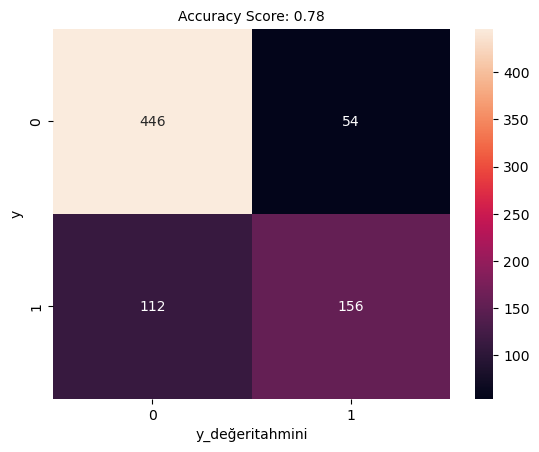

              precision    recall  f1-score   support

         0.0       0.80      0.89      0.84       500
         1.0       0.74      0.58      0.65       268

    accuracy                           0.78       768
   macro avg       0.77      0.74      0.75       768
weighted avg       0.78      0.78      0.78       768



In [64]:
######################################################
# Model Evaluation (Model Başarı Değerlendirme )
######################################################

def plot_confusion_matrix(y, y_değeritahmini):
    acc = round(accuracy_score(y, y_değeritahmini), 2)
    cm = confusion_matrix(y, y_değeritahmini)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_değeritahmini')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_değeritahmini)

print(classification_report(y, y_değeritahmini))

# Accuary = Doğru sınıflandırma oranı 
# Precision 1 olarak yazdığımız(yaptığımız) tahminler ne kadar başarılı
# Recal gerçekte 1 olanları ne kadar başarılı tahmin etmişiz 
# Precision ve Recal üzerinden de harmonik ortalama olan f1-score hesaplanıyor 

In [68]:
# Roc Auc nedir ? auc oluşabilecek farklı classifacation değerlerine karşı bir metrik

y_prob = log_model.predict_proba(X)[0:1]
roc_auc_score(y, y_değeritahmini)

0.737044776119403

In [72]:
######################################################
# Model Validation: Holdout   
# Model doğrulama 
# BuYaklaşım nasıl çalışıyordu = modelin bir kısmını eğit diğer kısmıyla test et
######################################################

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20, random_state=17)

In [73]:
log_model = LogisticRegression().fit(X_train, y_train)

y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

# değerler düştü 

              precision    recall  f1-score   support

         0.0       0.77      0.92      0.84        97
         1.0       0.79      0.53      0.63        57

    accuracy                           0.77       154
   macro avg       0.78      0.72      0.73       154
weighted avg       0.78      0.77      0.76       154



C:\Users\Monster\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


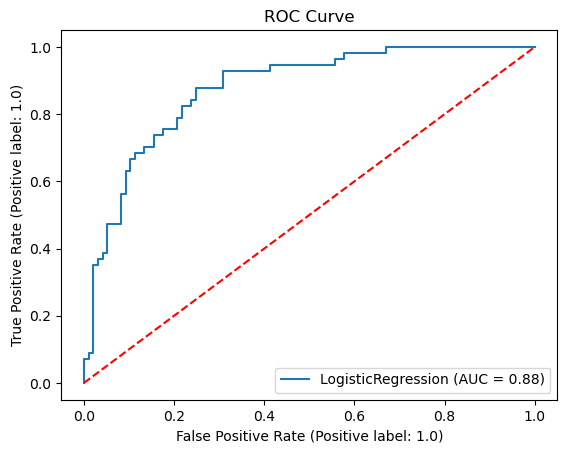

0.8755652016639537

In [74]:
plot_roc_curve(log_model, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

# AUC
roc_auc_score(y_test, y_prob)

In [80]:
######################################################
# Model Validation: 10-Fold Cross Validation
######################################################

y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

log_model = LogisticRegression().fit(X, y)

cv_results = cross_validate(log_model,
                            X, y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

In [ ]:
'''
Tüm parçaları 5'e ayır ve 
ondan sonra tek tek her birini test seti ve tren seti olarak ayarla 
bunların her birini ayrı ayrı ayarladıktan sonra bunların genel ortalamasını Al
İşte buna 10 katlı çapraz doğrulama denir'''

In [81]:
cv_results['test_accuracy'].mean()
# Accuracy: 0.7721

0.7721925133689839

In [82]:
cv_results['test_precision'].mean()
# Precision: 0.7192

0.7192472060223519

In [83]:
cv_results['test_recall'].mean()
# Recall: 0.5747

0.5747030048916841

In [85]:
cv_results['test_f1'].mean()
# F1-score: 0.6371

0.6371421090986309

In [86]:
cv_results['test_roc_auc'].mean()
# AUC: 0.8327

0.8327295597484277

In [84]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.600,0.752,0.000,0.375,-0.240,0.172,0.665,1.235,1.000
1,-0.400,-0.776,-0.333,0.188,-0.240,-0.581,-0.056,0.118,0.000
2,1.000,1.600,-0.444,-0.719,-0.240,-0.935,0.783,0.176,1.000
3,-0.400,-0.679,-0.333,0.000,0.499,-0.419,-0.537,-0.471,0.000
4,-0.600,0.485,-1.778,0.375,1.081,1.194,5.008,0.235,1.000


In [87]:
######################################################
# Prediction for A New Observation
######################################################
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype='object')

In [94]:
random_user = X.sample(1, random_state=65)
random_user

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
707,-0.200,0.242,-1.444,-0.062,2.393,0.258,-0.514,-0.412


In [95]:
log_model.predict(random_user)

array([0.])